In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from collections import OrderedDict
%matplotlib inline

#pd.options.display.mpl_style = 'default'
#pd.options.display.max_columns = 30
#pd.options.display.max_rows = 40

input_scales_csv = "RS2_QD_20141028a.csv"

### Search & display functions

In [15]:
# using this for inline documentation so that it's clear
# that the printing statement isn't part of the necessary
# transformation code.
def html_print(df):
    from IPython.display import HTML
    try:
        out = df.to_html()
    except AttributeError:
        out = pd.DataFrame(df).to_html()
    return HTML(out)


def htmljoin(df_list, delimiter=''):
    from IPython.display import HTML
    return HTML(delimiter.join([x.to_html() for x in df_list]))


def col_matches(df, regex):     
    import re    
    cols = list(enumerate(df.columns))        
    matches = [c for (i, c) in cols 
               if re.findall(regex, c)]        
    return matches


def concat_matches(df, *args):    
    assert all([len(r) for r in args])
    import re        
    col_match_lists = [col_matches(df, regex) for regex in args]    
    col_set = [df[matches] for matches in col_match_lists]    
    if len(col_set) == 0:
        return None    
    elif len(col_set) == 1:
        return col_set[0]    
    else:
        return pd.concat(col_set, axis=1)

    
def show_frames(frame_list, delimiter=''):    
    from IPython.display import HTML    
    if len(frame_list) == len(delimiter):        
        html_out = ""
        item_template = '<p><strong>{}</strong></p>{}<br>'        
        for i, tup in enumerate(zip(frame_list, delimiter)):
            frame = tup[0]
            tag = tup[1]
            html_out += item_template.format(tag, frame.to_html())            
        return HTML(html_out)        
    else:        
        html_out = [df.to_html() for df in frame_list]        
        return HTML(delimiter.join(html_out))
    
    
def compare_transformations(df, columns, functions, **kwargs):    
    print('raw')
    df[columns].hist(**kwargs)
    plt.show()    
    for name, func in functions.items():       
        print(name)        
        df[columns].apply(func).hist(**kwargs)
        plt.show()
        
        
def quickcompare(r, size=(15,7)): 
    return compare_transformations(dfo, col_matches(dfo, r),
                                   {'log1p': np.log1p,
                                    'sqrt':  np.sqrt,  },
                                   figsize=size)


### Load data and set participant ID index

In [3]:
dfo = pd.read_csv(input_scales_csv,
                       index_col='pid',
                       )

def add_leading_zeroes(pid):
    no_leading_zero = str(pid)
    with_leading_zeroes = '000'[len(no_leading_zero):] + no_leading_zero
    return with_leading_zeroes

dfo.index = dfo.reset_index('pid').pid.apply(add_leading_zeroes)

dfo[::12].T.head()

pid,015,028,041,056,068,081,094,107,119
session_day,20140228,20140305,20140326,20140408,20140414,20140423,20140501,20140506,20140509
session_time,1:00pm,3:40pm,1:00pm,11:00am,12:00nn,2:50pm,7:35am,12:00nn,3:00pm
session_isfemale,1,0,1,0,1,0,1,0,1
sex_femalezero,0,1,0,1,0,1,0,1,0
participant_age,21,18,23,21,19,20,22,20,19


## Missing values

In [4]:
#show missing values from original CSV entry ('77777')

html_print(dfo.loc['053'].head(10)) #example P with missing WASI subtest

,053
session_day,20140407
session_time,12:00nn
session_isfemale,1
sex_femalezero,0
participant_age,20
calc_wasivocab_totalrawscore,44
calc_wasimatrix_totalscore,77777
calc_wasivocab_tscore,61
calc_wasimatrix_tscore,77777
calc_wasi_tscore_total,77777


In [5]:
# Replace NaNs in note-taking columns with blanks for readability

def note_columns():
    note_columns = col_matches(dfo, "notes")
    assert len(note_columns) == 25
    
    more_note_columns = ['qbasic_ethnicityother',
                         'qmusic_dancestyle',
                         'qmusic_drumstyles',
                         'qmusic_instrumentlist',
                         'qmusic_gamenames']

    assert set(more_note_columns).issubset(dfo.columns)    
    note_columns += more_note_columns    
    assert len(note_columns) == 30    
    return note_columns

dfo.loc[:, note_columns()] = dfo.loc[:, note_columns()].fillna("")

# Replace missing data (coded "77777") with NaNs
# (but will change this back before exporting for external analyses)
dfo.replace('77777', np.nan, inplace=True)

html_print(dfo[30:40].T[18:22])

pid,049,051,052,053,054,055,056,057,058,059
order_500ms_first,1,0,1,1,1,1,1,1,1,1
order_rhythmfirst,0,1,0,1,0,0,1,0,0,0
notes_csv_cleaning,,,,"reset machine during ticks-linear-500, right w...",(1) Data for 054 has ID #055's first practice ...,first practice task's data is in the previous ...,,,,
notes_adminerror,,,,Matrix reasoning not completed (apparently for...,,,,,,


In [6]:
# View missing values
htmljoin([pd.DataFrame(row[row.isnull()])[:7].T 
          for i, row in dfo.iterrows()
          if len(row[row.isnull()]) > 0])

## Transforming questionnaire items

### Quantiles and dichotomizing

In [8]:
simple_hour_items = col_matches(dfo, 'hours$')  # '$' --> matches only end of name
simple_hour_items

['qmusic_singinghours',
 'qmusic_dancehours',
 'qmusic_instrumenthours',
 'qmusic_drumhours']

In [9]:
# Extreme floor effect for "practice hours" items when viewing
# the overall sample, so:
# Zero or nonzero monthly practice hours?

hour_counts_A = ['qmusic_singinghours',
                 'qmusic_singingtimes',
                 'qmusic_dancehours',
                 'qmusic_instrumenthours',
                 'qmusic_drumhours',
                 'qmusic_behaviors_09_danceprv', 
                 'qmusic_behaviors_10_dancepub',
                 'qmusic_gamehoursall',
                 'qmusic_gamehoursdrumsticks',
                 ]

for varname in hour_counts_A:
    s = dfo[varname]
    is_nonzero = (s > 0)  # --> False, True
    dfo[varname + '_nonzero'] = is_nonzero.astype(int) # --> 0, 1    

raw distributions:


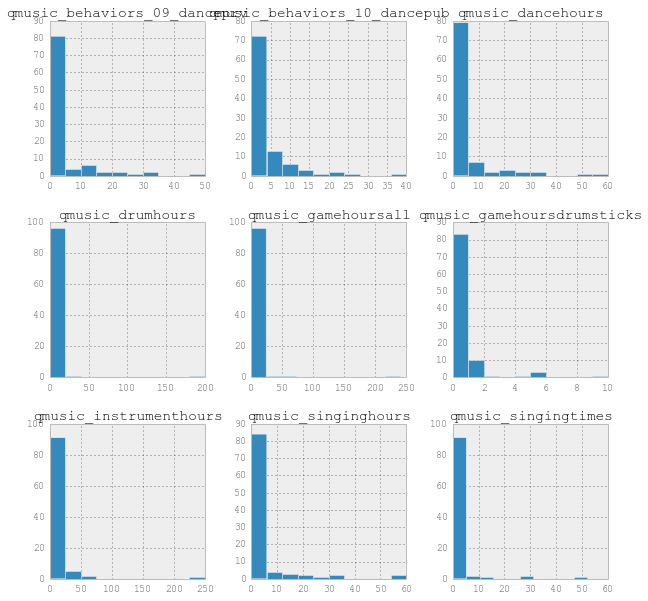

pid                                   015  016  017  018
qmusic_singinghours_nonzero             1    0    0    0
qmusic_singingtimes_nonzero             0    0    0    0
qmusic_dancehours_nonzero               1    1    0    1
qmusic_instrumenthours_nonzero          0    0    0    0
qmusic_drumhours_nonzero                0    0    0    0
qmusic_behaviors_09_danceprv_nonzero    1    1    0    1
qmusic_behaviors_10_dancepub_nonzero    0    1    0    1
qmusic_gamehoursall_nonzero             1    0    0    0
qmusic_gamehoursdrumsticks_nonzero      0    0    0    0


In [12]:
#pleasant matplotlib style set by pandas library
pd.options.display.mpl_style = 'default'

print('raw distributions:')
dfo[hour_counts_A].hist(figsize=(10,10))
plt.show()

print(concat_matches(dfo, '_nonzero$').head(4).T)

In [ ]:
pos_skewed_vars = ['qmusic_behaviors_07_yourself',
                   'qmusic_behaviors_08_otherprs',
                   'qmusic_behaviors_09_danceprv',
                   'qmusic_dancelevel']

raw


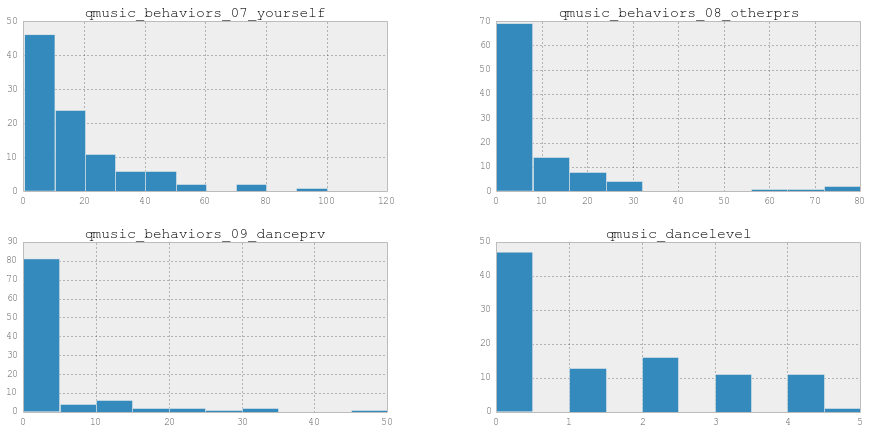

log1p


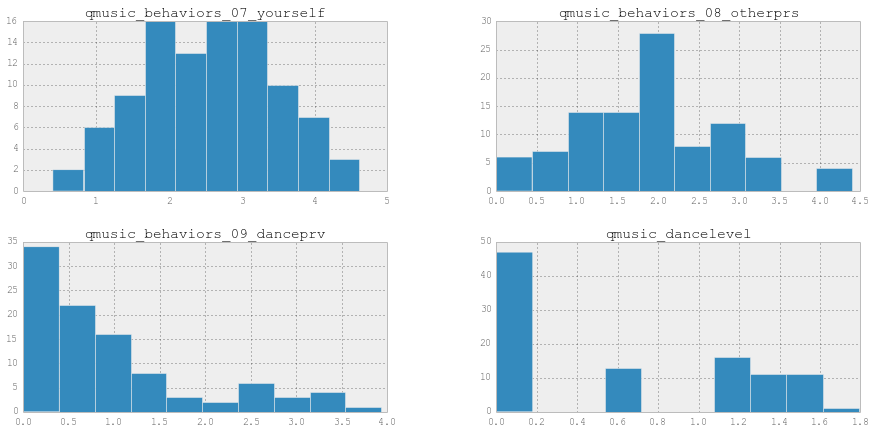

sqrt


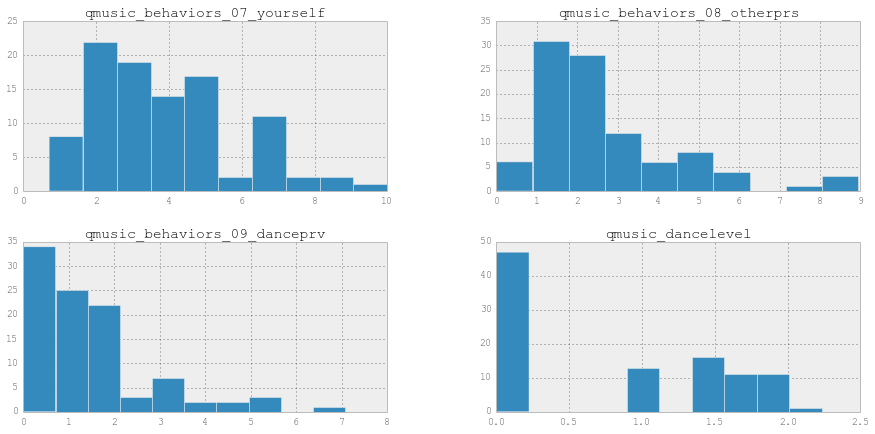

In [40]:
compare_transformations(dfo, pos_skewed_vars, 
                        {'log1p': np.log1p, 
                         'sqrt': np.sqrt,}, 
                        figsize=(15,7))

In [ ]:
for varname in pos_skewed_vars:
    s = dfo[varname]    
    dfo[varname + '_ln1p'] = np.log1p(s)  #ln of (x + 1)

raw


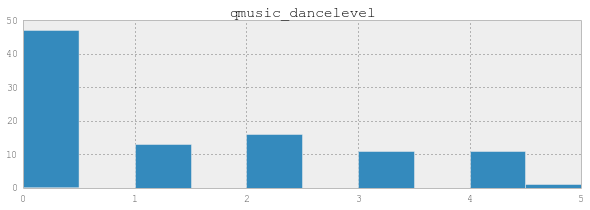

medsplit


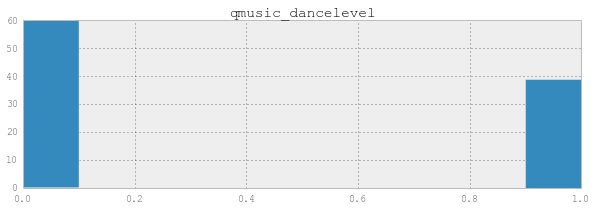

In [38]:
from functools import partial
medsplit = partial(pd.qcut, q=2, labels=False)

compare_transformations(dfo, 
                        ['qmusic_dancelevel'], 
                        {'medsplit': medsplit}, 
                        figsize=(10,3))

In [39]:
dfo['qmusic_dancelevel_tophalf'] = medsplit(dfo['qmusic_dancelevel'])
    # same as recoding as (0-1) --> 0
    #                     (2-7) --> 1

raw


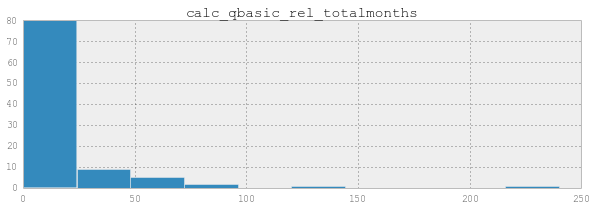

log1p


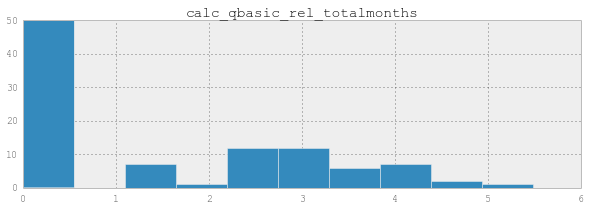

sqrt


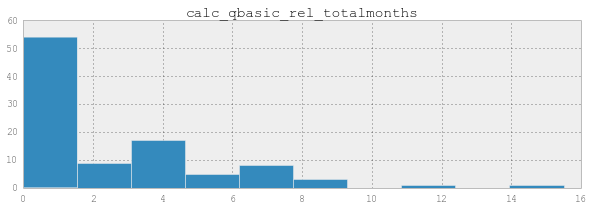

In [41]:
compare_transformations(dfo, 
                        col_matches(dfo, 'rel_totalmonths'), 
                        {'log1p': np.log1p,
                         'sqrt':  np.sqrt,  },
                        figsize=(10,3))

raw


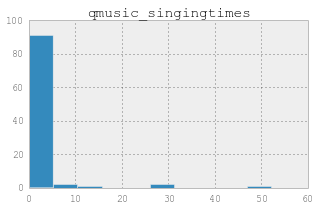

log1p


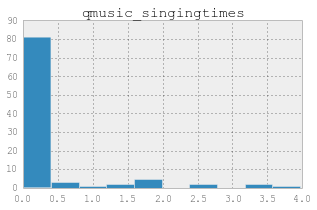

sqrt


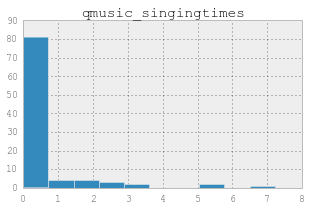

In [42]:
quickcompare('times$', size=(5,3))

In [49]:
#zero-indexed order of tasks of this ISI among the two types
dfo['orders_500'] = 1 - dfo.order_500ms_first
dfo['orders_800'] = 0 + dfo.order_500ms_first

# entered as strings in session_taskorder:
# 1. Iso, Lin, Phase
# 2. Iso, Phase, Lin
# 3. Lin, Iso, Phase
# 4. Lin, Phase, Iso
# 5. Phase, Iso, Lin
# 6. Phase, Lin, Iso

# first character (number indicating overall order)
order_n = dfo['session_taskorder'].apply(lambda x: int(x[0]))

#zero-indexed order of tasks of this type among the three types
isochronous_placement =  {1: 0,  2: 0,  3: 1,
                          4: 2,  5: 1,  6: 2,}

phaseshift_placement =   {1: 2,  2: 1,  3: 2,
                          4: 1,  5: 0,  6: 0,}

linearchange_placement = {1: 1,  2: 2,  3: 0,
                          4: 0,  5: 2,  6: 1,}

dfo['orders_iso'] =    order_n.apply(lambda x: isochronous_placement[x])
dfo['orders_phase'] =  order_n.apply(lambda x: phaseshift_placement[x])
dfo['orders_linear'] = order_n.apply(lambda x: linearchange_placement[x])

dfo['orderc_iso_before_lin'] = (dfo.orders_iso < dfo.orders_linear).astype(int)
dfo['orderc_iso_before_phase'] = (dfo.orders_iso < dfo.orders_phase).astype(int)
dfo['orderc_phase_before_lin'] = (dfo.orders_phase < dfo.orders_linear).astype(int)


# Set up precice ordering of each task in the set (1-indexed)
# practice trials of isochronous/single-stimulus
dfo['order_iso5t1'] =  dfo.orders_500 + 1
dfo['order_iso8t1'] =  dfo.orders_800 + 1

# +1 to set from zero-indexed to one-indexed,
# then +2 because the the first two have passed (iso5t1 and iso5t2)
dfo['order_iso5t2'] = 2 + (2 * dfo.orders_iso)    + dfo.orders_500 + 1
dfo['order_iso8t2'] = 2 + (2 * dfo.orders_iso)    + dfo.orders_800 + 1
dfo['order_psh5t'] =  2 + (2 * dfo.orders_phase)  + dfo.orders_500 + 1
dfo['order_psh8t'] =  2 + (2 * dfo.orders_phase)  + dfo.orders_800 + 1
dfo['order_lin5t'] =  2 + (2 * dfo.orders_linear) + dfo.orders_500 + 1
dfo['order_lin8t'] =  2 + (2 * dfo.orders_linear) + dfo.orders_800 + 1

dfo['order_iso5j'] = 6 + dfo['order_iso5t2'] #already adjusted to 1-index
dfo['order_iso8j'] = 6 + dfo['order_iso8t2']
dfo['order_psh5j'] = 6 + dfo['order_psh5t']
dfo['order_psh8j'] = 6 + dfo['order_psh8t']
dfo['order_lin5j'] = 6 + dfo['order_lin5t']
dfo['order_lin8j'] = 6 + dfo['order_lin8t']

dfo['order_isip5'] = dfo['order_iso5t1'] + 2 + 6 + 6
dfo['order_isip8'] = dfo['order_iso8t1'] + 2 + 6 + 6

html_print(concat_matches(dfo, '^order|taskorder')[::20].T.sort())

pid,015,037,060,081,102
order_500ms_first,0,0,0,0,1
order_isip5,16,16,16,16,15
order_isip8,15,15,15,15,16
order_iso5j,12,14,14,10,13
order_iso5t1,2,2,2,2,1
order_iso5t2,6,8,8,4,7
order_iso8j,11,13,13,9,14
order_iso8t1,1,1,1,1,2
order_iso8t2,5,7,7,3,8
order_lin5j,10,10,10,14,11


In [50]:
#Looking at high-end outliers, no transformations done here

hours_col_names = col_matches(dfo, 'hours')
hours_col_names += col_matches(dfo, 'behaviors_07')
hours_col_names += col_matches(dfo, 'behaviors_08')
hours_col_names += col_matches(dfo, 'behaviors_09')
hours_col_names += col_matches(dfo, 'behaviors_10')

hours_cols = dfo[hours_col_names]

frames = [hours_cols.sort(c, ascending=False).head(8).T 
          for c in hours_cols.columns]

show_frames(frames, hours_col_names)

#log_hours_columns = np.log1p(hours_cols)
#log_hours_columns.sort(col)

pid,075,041,033,066,078,056,110,107
qmusic_singinghours,60.000000,55.000000,30.000000,30.000000,27.000000,20.000000,20.000000,17.500000
qmusic_dancehours,0.000000,2.000000,4.000000,16.000000,6.000000,0.000000,0.000000,0.000000
qmusic_instrumenthours,24.000000,8.000000,70.000000,60.000000,28.000000,20.000000,30.000000,5.000000
qmusic_gamehoursall,2.000000,0.000000,0.000000,20.000000,3.000000,20.000000,0.000000,60.000000
qmusic_gamehoursdrumsticks,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
qmusic_drumhours,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
qmusic_singinghours_nonzero,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
qmusic_dancehours_nonzero,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
qmusic_instrumenthours_nonzero,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
qmusic_drumhours_nonzero,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


raw


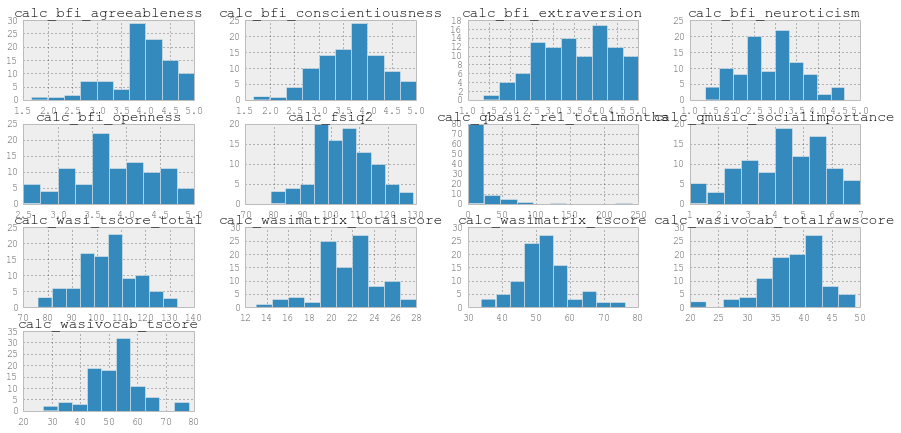

log1p


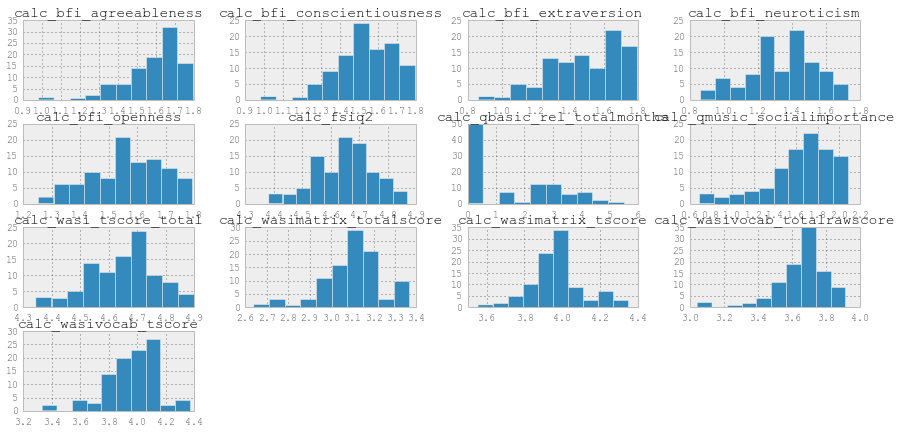

sqrt


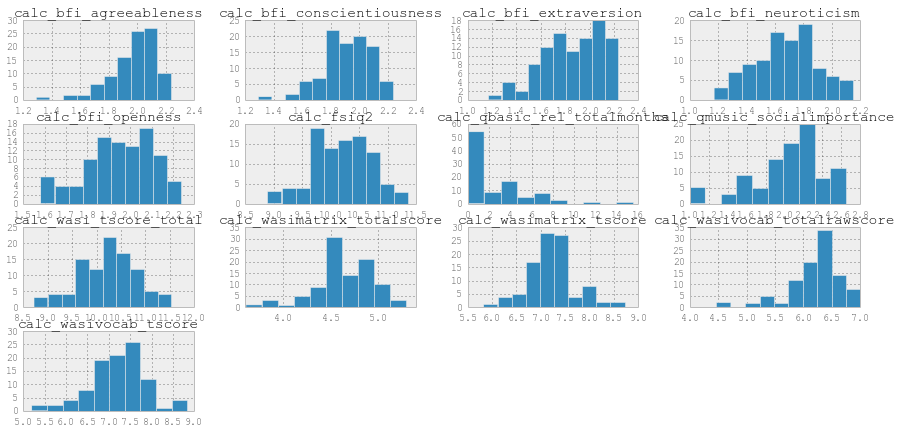

In [51]:
quickcompare('^calc')

In [52]:
concat_matches(dfo, 'sumhours', 'qmusic_dance', 'iq').T

pid,015,016,017,018,019,020,021,022,024,025,...,112,113,114,115,116,117,118,119,120,121
notes_qmusic_dance,,,(Was a kids dancing program at my elementary s...,,,,,,,,...,,,,,,20 hours = zumba dance fitness + belly dance,,,,
qmusic_danceyn,1,1,1,1,1,0,0,0,1,1,...,1,0,1,1,1,1,1,1,0,0
qmusic_dancestyle,ballet,show choir,NDI,"ballroom, country (2-step)",jazz,,,,ballroom,ballroom dance,...,variety of dance,(blank),ballet,ballroom,hip hop,belly dance,hip hop,"pop, ballet",,
qmusic_dancelevel,2,2,1,3,4,0,0,0,1,3,...,5,0,3,2,3,4,3,3,0,0
qmusic_dancehours,20,1,0,10,50,0,0,0,5,8,...,2,0,10,5,3,20,24,60,0,0
qmusic_dancehours_nonzero,1,1,0,1,1,0,0,0,1,1,...,1,0,1,1,1,1,1,1,0,0
qmusic_dancelevel_ln1p,1.098612,1.098612,0.6931472,1.386294,1.609438,0,0,0,0.6931472,1.386294,...,1.791759,0,1.386294,1.098612,1.386294,1.609438,1.386294,1.386294,0,0
qmusic_dancelevel_tophalf,1,1,0,1,1,0,0,0,0,1,...,1,0,1,1,1,1,1,1,0,0
calc_fsiq2,89,127,108,102,109,105,95,102,99,95,...,87,94,122,123,120,95,108,105,100,97


In [54]:
#Finally: set NaNs back to '77777'
dfo.replace(np.nan, '77777', inplace=True)

scales_output_updated = '2014-10-29a'
prefix = "c:/db_pickles/pickle - dfo-scales - "

import cPickle as pickle
output_file= prefix + scales_output_updated + '.pickle'
pickle.dump(dfo, open(output_file, "wb"))

# Proceed with pickle to Part 5